In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

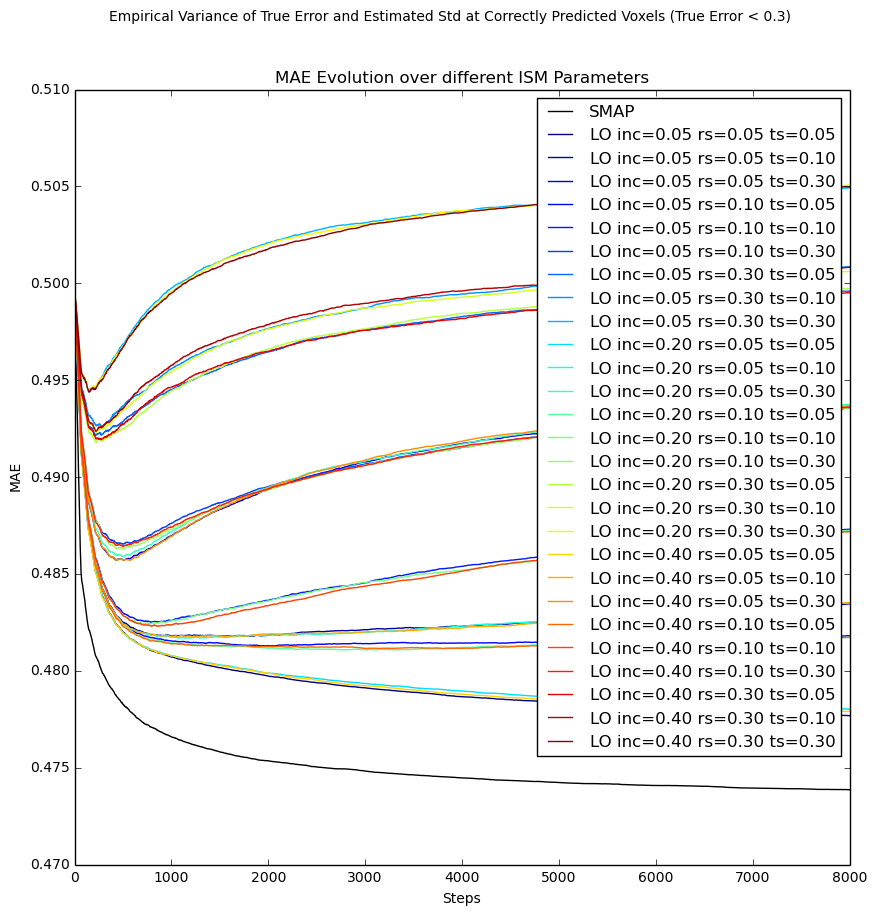

In [84]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle("Empirical Variance of True Error and Estimated Std at Correctly Predicted Voxels (True Error < 0.3)")

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]

for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
    if rnd == 0:
        errBelief = np.array(stats.errorEvolutionBelief)
        ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.array(stats.errorEvolutionLogOdds)
    ax.plot(errLogOdds, color=colors[rnd], label="LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize))
    
ax.set_title("MAE Evolution over different ISM Parameters")
ax.set_ylabel("MAE")
ax.set_xlabel("Steps")
ax.legend()

0 LO inc=0.05 rs=0.05 ts=0.05
1 LO inc=0.05 rs=0.05 ts=0.10
2 LO inc=0.05 rs=0.05 ts=0.30
3 LO inc=0.05 rs=0.10 ts=0.05
4 LO inc=0.05 rs=0.10 ts=0.10
5 LO inc=0.05 rs=0.10 ts=0.30
6 LO inc=0.05 rs=0.30 ts=0.05
7 LO inc=0.05 rs=0.30 ts=0.10
8 LO inc=0.05 rs=0.30 ts=0.30
9 LO inc=0.20 rs=0.05 ts=0.05
10 LO inc=0.20 rs=0.05 ts=0.10
11 LO inc=0.20 rs=0.05 ts=0.30
12 LO inc=0.20 rs=0.10 ts=0.05
13 LO inc=0.20 rs=0.10 ts=0.10
14 LO inc=0.20 rs=0.10 ts=0.30
15 LO inc=0.20 rs=0.30 ts=0.05
16 LO inc=0.20 rs=0.30 ts=0.10
17 LO inc=0.20 rs=0.30 ts=0.30
18 LO inc=0.40 rs=0.05 ts=0.05
19 LO inc=0.40 rs=0.05 ts=0.10
20 LO inc=0.40 rs=0.05 ts=0.30
21 LO inc=0.40 rs=0.10 ts=0.05
22 LO inc=0.40 rs=0.10 ts=0.10
23 LO inc=0.40 rs=0.10 ts=0.30
24 LO inc=0.40 rs=0.30 ts=0.05
25 LO inc=0.40 rs=0.30 ts=0.10
26 LO inc=0.40 rs=0.30 ts=0.30


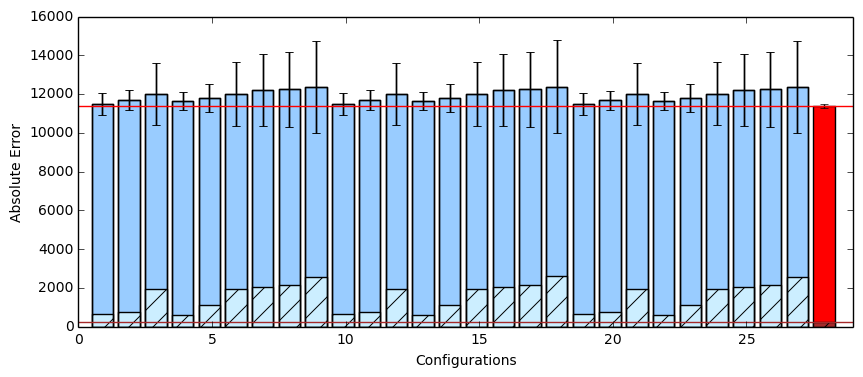

In [98]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"


k = 2

inconsistencies = []
labels = []
errors = []
errors_overconfident = []
smapInconsistency = 0
smapError = 0
smapError_overconfident = 0
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.abs(np.array(stats.errorFinalUpdatedLogOdds))
    stdLogOdds = np.array(stats.stdFinalUpdatedLogOdds)
    errBelief = np.abs(np.array(stats.errorFinalUpdatedBelief))
    stdBelief = np.array(stats.stdFinalUpdatedBelief)
    
#     mask = (errLogOdds > 0.6) | (errBelief > 0.6)
#     errLogOdds = errLogOdds[mask]
#     stdLogOdds = stdLogOdds[mask]
#     errBelief = errBelief[mask]
#     stdBelief = stdBelief[mask]
    
    inconsistencies.append(np.sum([max(0, err - k * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    errors.append(np.sum(errLogOdds))
    errors_overconfident.append(np.sum(errLogOdds[errLogOdds - k * stdLogOdds > 0]))
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    labels.append(label)
    print rnd, label
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == 0: #len(filenames)-1:
        smapError = np.sum(errBelief)
        smapInconsistency = np.sum([max(0, err - k * std * 1.724) for err, std in zip(errBelief, stdBelief)])
        smapError_overconfident = np.sum(errBelief[errBelief - k * stdBelief * 1.724 > 0])
        #print "Smap Inconsistency:", smapInconsistency

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="#99ccff", ecolor="black")
#ax.bar(np.array(list(range(len(errors))))+.5, errors, color="#006699", ecolor="black")
ax.bar(np.array(list(range(len(errors))))+.5, errors_overconfident, color="#cceeff", hatch='/')
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])


ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
ax.plot([0, len(errors)+2], [smapError_overconfident,smapError_overconfident], color="brown")

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency], color="r", ecolor="black")
#ax.bar([len(errors)+.5], [smapError], color="r", ecolor="black")
ax.bar([len(errors)+.5], [smapError_overconfident], color="brown", ecolor="black", hatch='/')


ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="", ecolor="black")
    
#ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configurations")
ax.set_xlim([0,len(errors)+2])
ax.legend()
plt.savefig("ism_evaluation.pdf")

ISM inconsistency: 0.941646184342
0 LO inc=0.05 rs=0.05 ts=0.05
Smap Inconsistency: 38.8600354856
ISM inconsistency: 8.72816257825
1 LO inc=0.05 rs=0.05 ts=0.10
ISM inconsistency: 164.644464883
2 LO inc=0.05 rs=0.05 ts=0.30
ISM inconsistency: 2.8779574309
3 LO inc=0.05 rs=0.10 ts=0.05
ISM inconsistency: 23.4155212117
4 LO inc=0.05 rs=0.10 ts=0.10
ISM inconsistency: 184.050166428
5 LO inc=0.05 rs=0.10 ts=0.30
ISM inconsistency: 352.867204512
6 LO inc=0.05 rs=0.30 ts=0.05
ISM inconsistency: 383.472370821
7 LO inc=0.05 rs=0.30 ts=0.10
ISM inconsistency: 567.463288977
8 LO inc=0.05 rs=0.30 ts=0.30
ISM inconsistency: 1.42986856902
9 LO inc=0.20 rs=0.05 ts=0.05
ISM inconsistency: 9.53798161864
10 LO inc=0.20 rs=0.05 ts=0.10
ISM inconsistency: 164.282658597
11 LO inc=0.20 rs=0.05 ts=0.30
ISM inconsistency: 2.09493717158
12 LO inc=0.20 rs=0.10 ts=0.05
ISM inconsistency: 23.6938937873
13 LO inc=0.20 rs=0.10 ts=0.10
ISM inconsistency: 185.049270595
14 LO inc=0.20 rs=0.10 ts=0.30
ISM inconsistenc

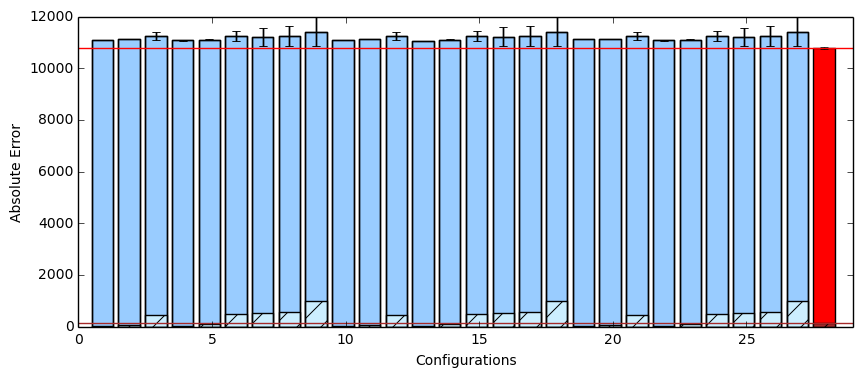

In [101]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs_fewsteps_noise0.05/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs_fewsteps_noise0.05/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"


k = 2

inconsistencies = []
labels = []
errors = []
errors_overconfident = []
smapInconsistency = 0
smapError = 0
smapError_overconfident = 0
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.abs(np.array(stats.errorFinalUpdatedLogOdds))
    stdLogOdds = np.array(stats.stdFinalUpdatedLogOdds)
    errBelief = np.abs(np.array(stats.errorFinalUpdatedBelief))
    stdBelief = np.array(stats.stdFinalUpdatedBelief)
    
#     mask = (errLogOdds > 0.6) | (errBelief > 0.6)
#     errLogOdds = errLogOdds[mask]
#     stdLogOdds = stdLogOdds[mask]
#     errBelief = errBelief[mask]
#     stdBelief = stdBelief[mask]
    
    inconsistencies.append(np.sum([max(0, err - k * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    print "ISM inconsistency:", inconsistencies[-1]
    errors.append(np.sum(errLogOdds))
    errors_overconfident.append(np.sum(errLogOdds[errLogOdds - k * stdLogOdds > 0]))
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    labels.append(label)
    print rnd, label
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == 0: #len(filenames)-1:
        smapError = np.sum(errBelief)
        smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
        smapError_overconfident = np.sum(errBelief[errBelief - k * stdBelief > 0])
        print "Smap Inconsistency:", smapInconsistency

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="#99ccff", ecolor="black")
#ax.bar(np.array(list(range(len(errors))))+.5, errors, color="#006699", ecolor="black")
ax.bar(np.array(list(range(len(errors))))+.5, errors_overconfident, color="#cceeff", hatch='/')
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])


ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
ax.plot([0, len(errors)+2], [smapError_overconfident,smapError_overconfident], color="brown")

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency], color="r", ecolor="black")
#ax.bar([len(errors)+.5], [smapError], color="r", ecolor="black")
ax.bar([len(errors)+.5], [smapError_overconfident], color="brown", ecolor="black", hatch='/')


ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="", ecolor="black")
    
#ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configurations")
ax.set_xlim([0,len(errors)+2])
ax.legend()
plt.savefig("ism_evaluation.pdf")

0 LO inc=0.05 rs=0.05 ts=0.05
Smap Inconsistency: 5.90425507021
1 LO inc=0.05 rs=0.05 ts=0.10
2 LO inc=0.05 rs=0.05 ts=0.30
3 LO inc=0.05 rs=0.10 ts=0.05
4 LO inc=0.05 rs=0.10 ts=0.10
5 LO inc=0.05 rs=0.10 ts=0.30
6 LO inc=0.05 rs=0.30 ts=0.05
7 LO inc=0.05 rs=0.30 ts=0.10
8 LO inc=0.05 rs=0.30 ts=0.30
12 LO inc=0.20 rs=0.05 ts=0.05
13 LO inc=0.20 rs=0.05 ts=0.10
14 LO inc=0.20 rs=0.05 ts=0.30
15 LO inc=0.20 rs=0.10 ts=0.05
16 LO inc=0.20 rs=0.10 ts=0.10
17 LO inc=0.20 rs=0.10 ts=0.30
18 LO inc=0.20 rs=0.30 ts=0.05
19 LO inc=0.20 rs=0.30 ts=0.10
20 LO inc=0.20 rs=0.30 ts=0.30
24 LO inc=0.40 rs=0.05 ts=0.05
25 LO inc=0.40 rs=0.05 ts=0.10
26 LO inc=0.40 rs=0.05 ts=0.30
27 LO inc=0.40 rs=0.10 ts=0.05
28 LO inc=0.40 rs=0.10 ts=0.10
29 LO inc=0.40 rs=0.10 ts=0.30
30 LO inc=0.40 rs=0.30 ts=0.05
31 LO inc=0.40 rs=0.30 ts=0.10
32 LO inc=0.40 rs=0.30 ts=0.30


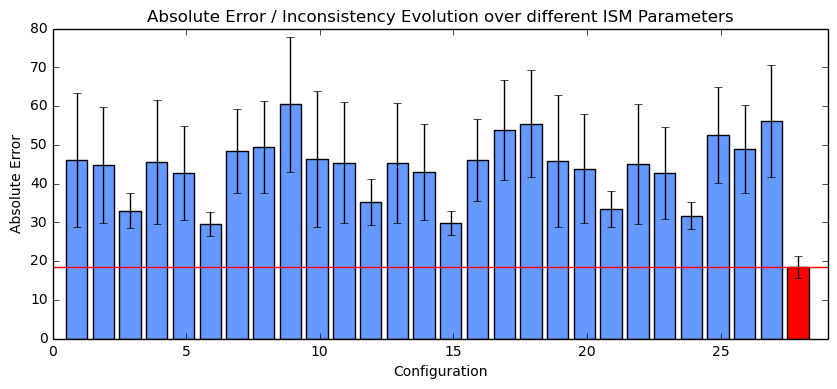

In [107]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"

inconsistencies = []
labels = []
errors = []
smapInconsistency = 0
smapError = 0
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
    if stats.ismRampSize > .5:
        continue
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
#     errLogOdds = np.abs(np.array(stats.errorFinalUpdatedLogOdds))
#     errBelief = np.abs(np.array(stats.errorFinalUpdatedBelief))
#     stdLogOdds = np.array(stats.stdFinalUpdatedLogOdds)
#     stdBelief = np.array(stats.stdFinalUpdatedBelief)
    
    
#     errLogOdds = np.abs(np.array(stats.errorLogOdds))
#     errBelief = np.abs(np.array(stats.errorBelief))
#     stdLogOdds = np.array(stats.stdLogOdds)
#     stdBelief = np.array(stats.stdBelief)
    
#     prior_error = np.nonzero((np.abs(errLogOdds - .5) > 0.01) & (np.abs(errBelief - .5) > 0.01))
#     #print len(prior_error[0])
    
#     errLogOdds = errLogOdds[prior_error]
#     errBelief = errBelief[prior_error]
#     stdLogOdds = stdLogOdds[prior_error]
#     stdBelief = stdBelief[prior_error]
    
    errLogOdds = np.abs(np.array(stats.errorCompleteUpdatedLogOdds[-stats.updatedVoxels[-1]:]))
    errBelief = np.abs(np.array(stats.errorCompleteUpdatedBelief[-stats.updatedVoxels[-1]:]))
    stdLogOdds = np.array(stats.stdCompleteUpdatedLogOdds[-stats.updatedVoxels[-1]:])
    stdBelief = np.array(stats.stdCompleteUpdatedBelief[-stats.updatedVoxels[-1]:])
    
    k = 1
    inconsistencies.append(np.sum([max(0, err - k * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    errors.append(np.sum(errLogOdds))
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    print rnd, label
    labels.append(label)
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == 0:
        smapError = np.sum(errBelief)
        smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
        print "Smap Inconsistency:", smapInconsistency

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=np.array(inconsistencies)/2, color="#6699ff", ecolor="black")
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency/2], color="r", ecolor="black")

ax.plot([0, len(errors)+2], [smapError,smapError], color="r")
    
ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configuration")
ax.set_xlim([0,len(errors)+2])
ax.legend()
plt.savefig("ism_evaluation.pdf")